### Modules Imports

In [1]:
import os
import time
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import QuantileDiscretizer

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# visualization customization
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 7]

---
# Data Importation

In [2]:
PRO_DIR = os.path.abspath('')
DATA_DIR = os.path.join(PRO_DIR, 'data/')

In [3]:
print(DATA_DIR)
accounts_PATH = f'{DATA_DIR}accounts_clean'
contracts_PATH = f'{DATA_DIR}contracts_clean'
metrics_PATH = f'{DATA_DIR}metrics_clean'
business_PATH = f'{DATA_DIR}business_df'

/Users/sam/Documents/RedPoint/data/


In [4]:
spark = SparkSession \
    .builder \
    .appName("Explore_data") \
    .getOrCreate()

22/02/22 16:17:22 WARN Utils: Your hostname, Sams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.48 instead (on interface en0)
22/02/22 16:17:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/22 16:17:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 16:17:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/22 16:17:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
accounts_df = spark.read.csv(
    accounts_PATH,
    inferSchema=True,
    header=True
)

In [6]:
contracts_df = spark.read.csv(
    contracts_PATH,
    inferSchema=True,
    header=True
)

In [7]:
metrics_df = spark.read.csv(
    metrics_PATH,
    inferSchema=True,
    header=True
)

In [8]:
df_business = spark.read.csv(
    business_PATH,
    inferSchema=True,
    header=True
)

In [9]:
df = spark.sql("SELECT * FROM parquet.`data/complete_df.parquet`")

---

# Insights

In [10]:
accounts_df.groupby('account_status').count().show()

+--------------+-----+
|account_status|count|
+--------------+-----+
|        Paused|   56|
|     Cancelled|  359|
|        Active|  505|
+--------------+-----+



#### How many contracts usually customers sign with Red Points?

22/02/22 16:17:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


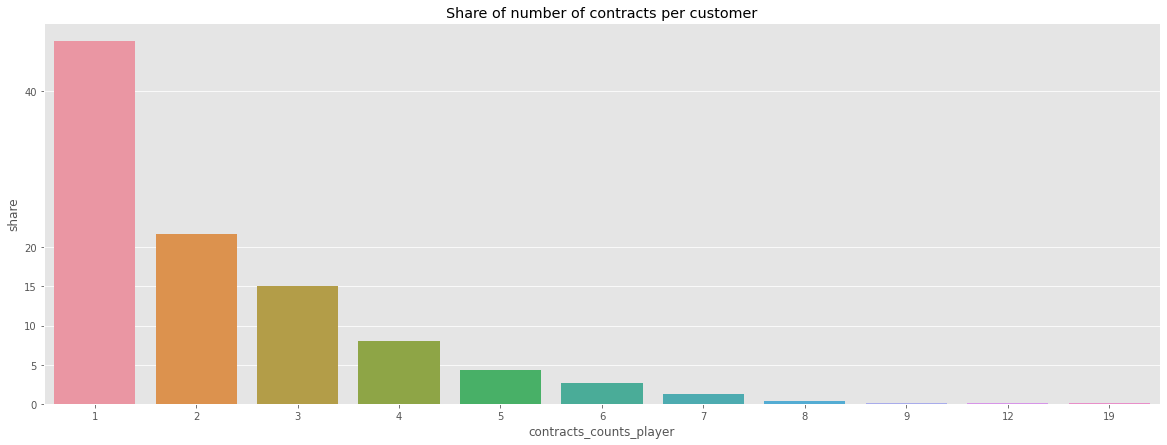

In [11]:
plot = sns.barplot(
    x='contracts_counts_player',
    y='share',
    data=contracts_df.groupby('account_id').agg(
        count('account_id').alias('contracts_counts_player')
    ).groupby('contracts_counts_player').count().withColumn('share', round((col('count')/sum('count').over(Window.partitionBy()) * 100), 2)).sort('contracts_counts_player').toPandas()
)

plot.set_title('Share of number of contracts per customer')
plot.yaxis.set_major_locator(ticker.FixedLocator([0, 5, 10, 15, 20, 40, 50]))

As we can see, almost 50 percent of customers have just one contract, and they don't renew their contracts.

---

In [12]:
df.groupby('isChurn').count().show()

+-------+------+
|isChurn| count|
+-------+------+
|      1|136694|
|      0|386557|
+-------+------+



We can see here that customers with more metrics data (daily reports(?)), they tend to stay with us.

### **Let's check the data for an active useres and for a canceled user [churned].**
#### An active customer:

In [13]:
# Activities for an active customer
metrics_df.filter(col('accountid') == '0010Y00000JROoy').groupby(month('date')).max().sort('month(date)').show(100)

+-----------+---------------+------------+-----------+------------------+------------------+-------------------+--------------+-----------+--------------------+
|month(date)|max(detections)|max(matches)|max(alerts)|max(infringements)|max(inf_confirmed)|max(on_enforcement)|max(takedowns)|max(closed)|max(non_enforceable)|
+-----------+---------------+------------+-----------+------------------+------------------+-------------------+--------------+-----------+--------------------+
|          1|            695|        2432|        503|               234|               171|                128|           728|        427|                  17|
|          2|           1067|        1024|        749|               232|               233|                280|           201|         60|                  17|
|          3|            383|        1078|        499|               687|               691|                430|           289|        132|                  54|
|          4|           1660|     

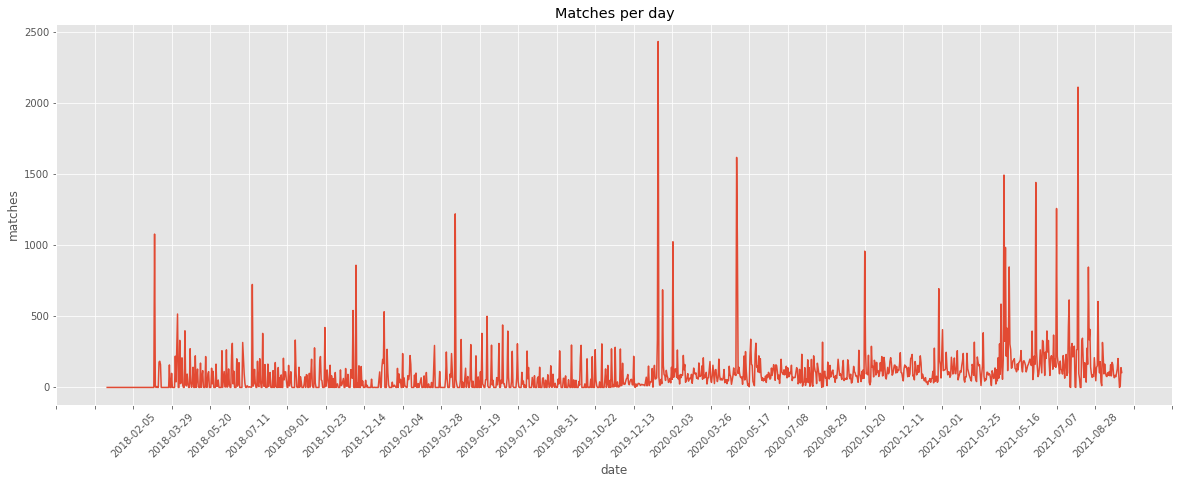

In [14]:
plot = sns.lineplot(
    x='date',
    y='matches',
    data=metrics_df.filter(
        (col('accountid') == '0010Y00000JROoy')
    ).select('date', 'matches').sort('date').toPandas()
)
plot.set_title('Matches per day')
plot.set_xlabel('date')
plot.tick_params(axis='x', rotation=45)
plot.xaxis.set_major_locator(ticker.LinearLocator(30))

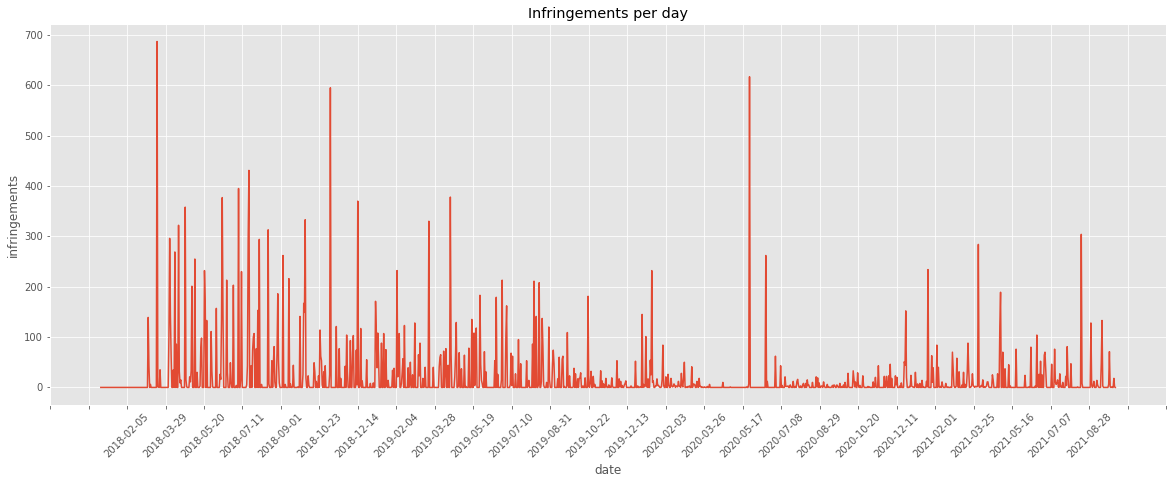

In [15]:
plot = sns.lineplot(
    x='date',
    y='infringements',
    data=metrics_df.filter(
        (col('accountid') == '0010Y00000JROoy')
    ).select('date', 'infringements').sort('date').toPandas()
)
plot.set_title('Infringements per day')
plot.set_xlabel('date')
plot.tick_params(axis='x', rotation=45)
plot.xaxis.set_major_locator(ticker.LinearLocator(30))

### A canceled customer

In [16]:
# Activities for a canceled customer
metrics_df.filter(col('accountid') == '0011n00001pYB8m').groupby(month('date')).max().sort('month(date)').show(100)

+-----------+---------------+------------+-----------+------------------+------------------+-------------------+--------------+-----------+--------------------+
|month(date)|max(detections)|max(matches)|max(alerts)|max(infringements)|max(inf_confirmed)|max(on_enforcement)|max(takedowns)|max(closed)|max(non_enforceable)|
+-----------+---------------+------------+-----------+------------------+------------------+-------------------+--------------+-----------+--------------------+
|          1|             21|          24|         77|                 0|                 0|                  0|             0|          0|                   0|
|          2|             72|          74|         72|                35|                35|                 14|            14|          1|                  12|
|          3|             79|          76|         58|                 7|                 7|                  1|             3|          2|                   0|
|          4|             44|     

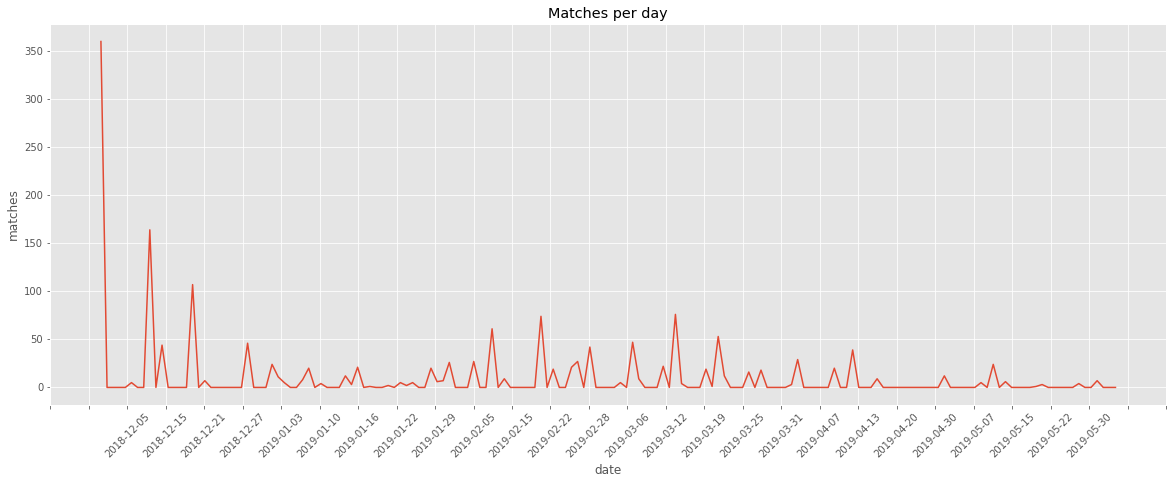

In [17]:
plot = sns.lineplot(
    x='date',
    y='matches',
    data=metrics_df.filter(
        (col('accountid') == '0011n00001pYB8m')
    ).select('date', 'matches').sort('date').toPandas()
)
plot.set_title('Matches per day')
plot.set_xlabel('date')
plot.tick_params(axis='x', rotation=45)
plot.xaxis.set_major_locator(ticker.LinearLocator(30))

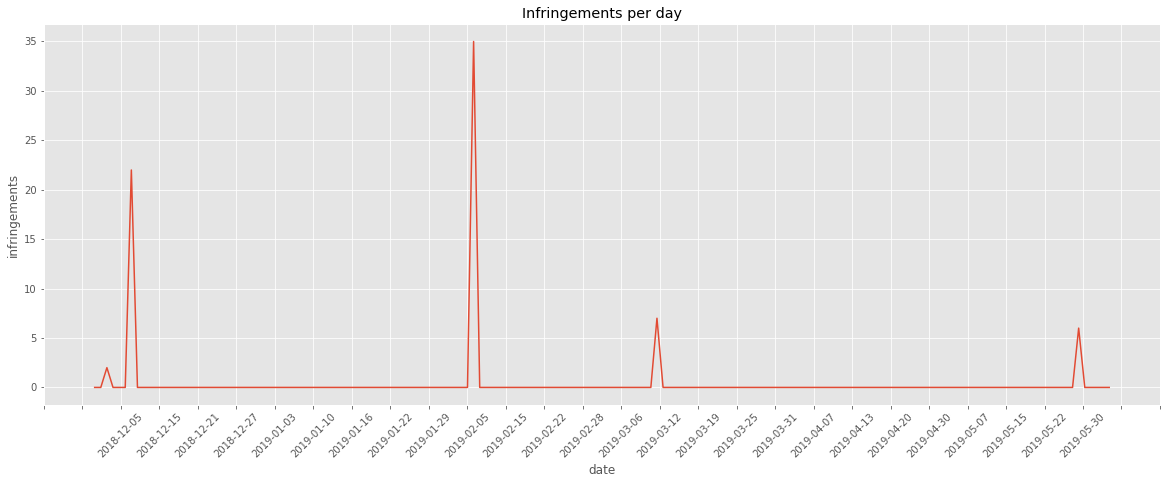

In [18]:
plot = sns.lineplot(
    x='date',
    y='infringements',
    data=metrics_df.filter(
        (col('accountid') == '0011n00001pYB8m')
    ).select('date', 'infringements').sort('date').toPandas()
)
plot.set_title('Infringements per day')
plot.set_xlabel('date')
plot.tick_params(axis='x', rotation=45)
plot.xaxis.set_major_locator(ticker.LinearLocator(30))

---

In [19]:
df.groupby('isChurn').agg(
    mean('tenure'),
    min('tenure'),
    max('tenure')
).show()

+-------+------------------+-----------+-----------+
|isChurn|       avg(tenure)|min(tenure)|max(tenure)|
+-------+------------------+-----------+-----------+
|      1|10.130554376929492|        1.0|       29.0|
|      0|12.460534927578598|        1.0|       49.0|
+-------+------------------+-----------+-----------+



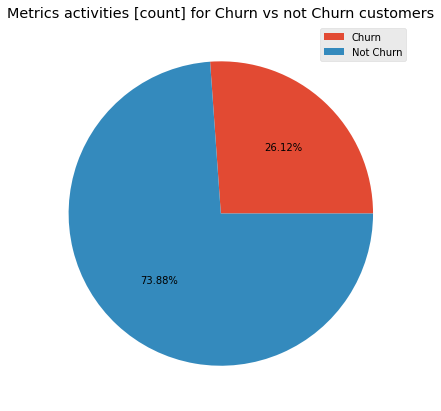

In [20]:
plot = plt.pie(
    x='count',
    autopct='%1.2f%%',
    data=df.groupby('isChurn').count().toPandas()
)
plt.title('Metrics activities [count] for Churn vs not Churn customers')
plt.legend(['Churn', 'Not Churn'])

As expected, the customers who churned had less activities [reports] compare the not churned customers

Text(0.5, 1.0, 'Company type count for isChurn vs not isChurn customers')

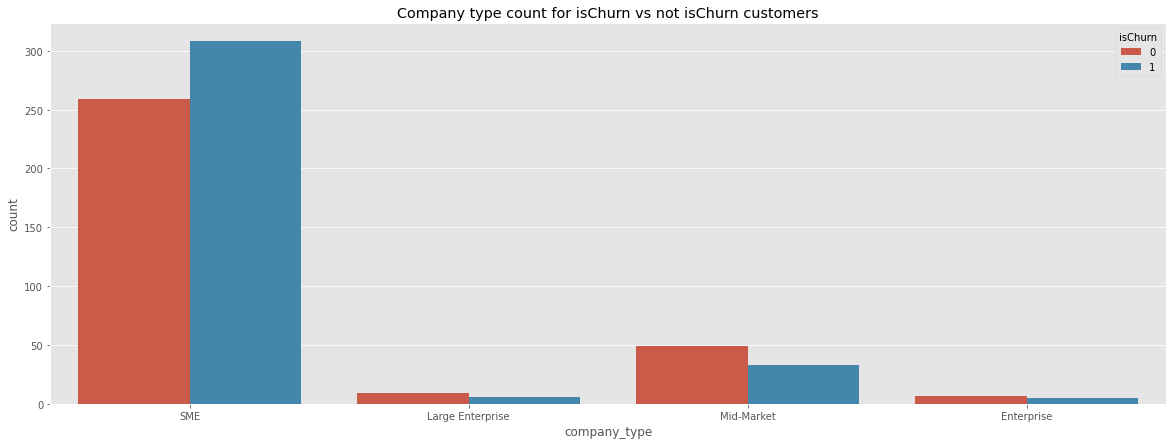

In [21]:
plot = sns.barplot(
    x='company_type',
    y='count',
    hue='isChurn',
    data=df_business.groupby('isChurn', 'company_type').agg(count('company_type').alias('count')).toPandas()
)
plot.set_title('Company type count for isChurn vs not isChurn customers')

We could also say that our products are more valued between mid-size to larg corpates.

Text(0.5, 1.0, '6 months Opt Out. count for churn vs not churn customers')

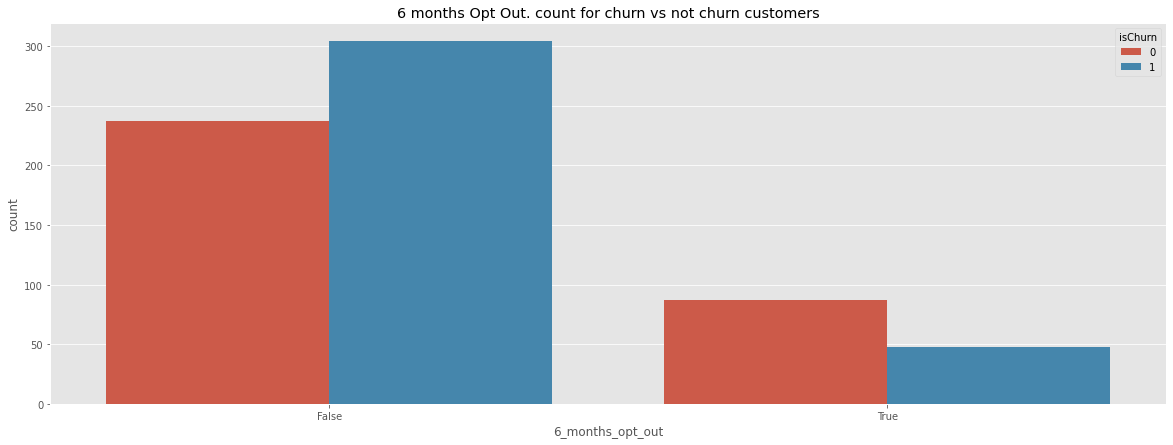

In [22]:
plot = sns.barplot(
    x='6_months_opt_out',
    y='count',
    hue='isChurn',
    data=df_business.groupby('isChurn', '6_months_opt_out').agg(count('6_months_opt_out').alias('count')).toPandas()
)
plot.set_title('6 months Opt Out. count for churn vs not churn customers')

Text(0.5, 1.0, 'Account type count for churn vs not churn customers')

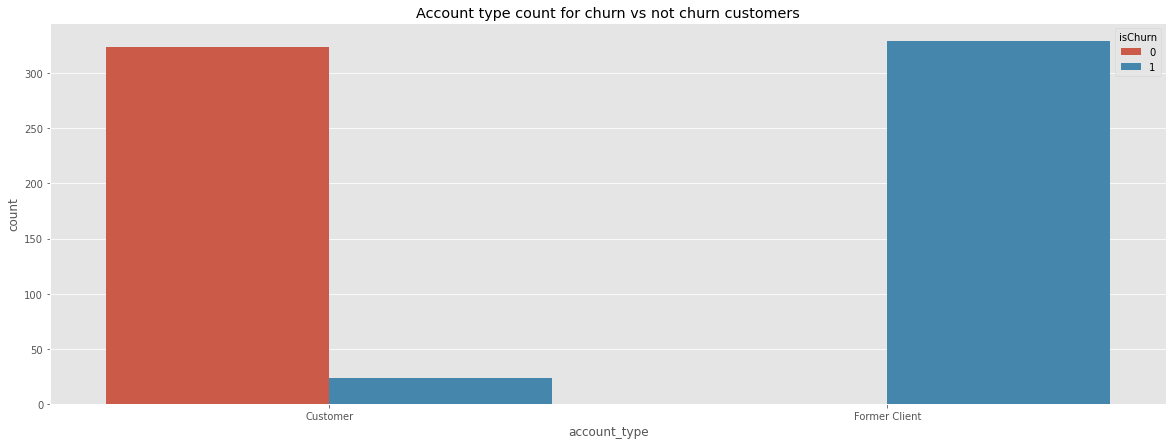

In [23]:
plot = sns.barplot(
    x='account_type',
    y='count',
    hue='isChurn',
    data=df_business.groupby('isChurn', 'account_type').agg(count('account_type').alias('count')).toPandas()
)
plot.set_title('Account type count for churn vs not churn customers')

As we can see here, this feature is not very helpful for model training. I exclude this from the training data.

Text(0.5, 1.0, 'Contract type count for churn vs not churn customers')

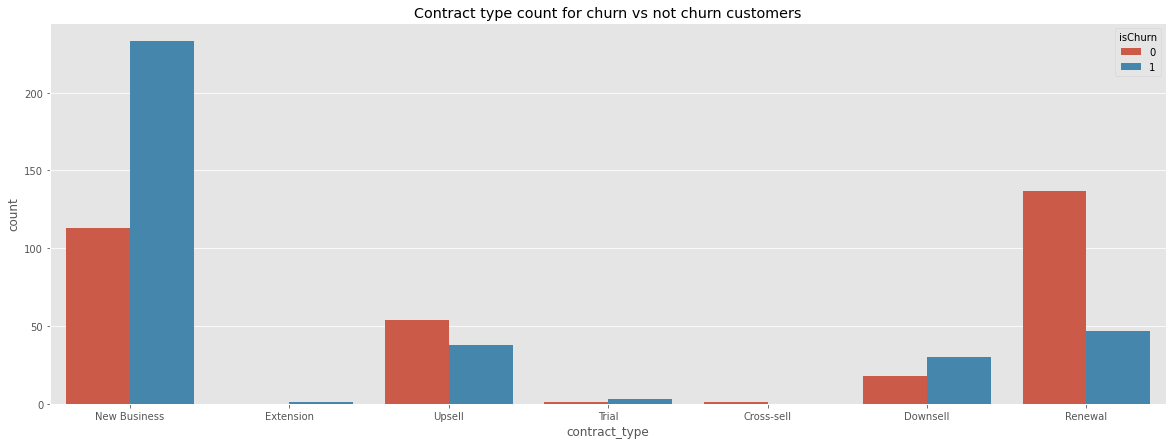

In [24]:
plot = sns.barplot(
    x='contract_type',
    y='count',
    hue='isChurn',
    data=df_business.groupby('isChurn', 'contract_type').agg(count('contract_type').alias('count')).toPandas()
)
plot.set_title('Contract type count for churn vs not churn customers')

Text(0.5, 1.0, 'Contract type count for churn vs not churn customers')

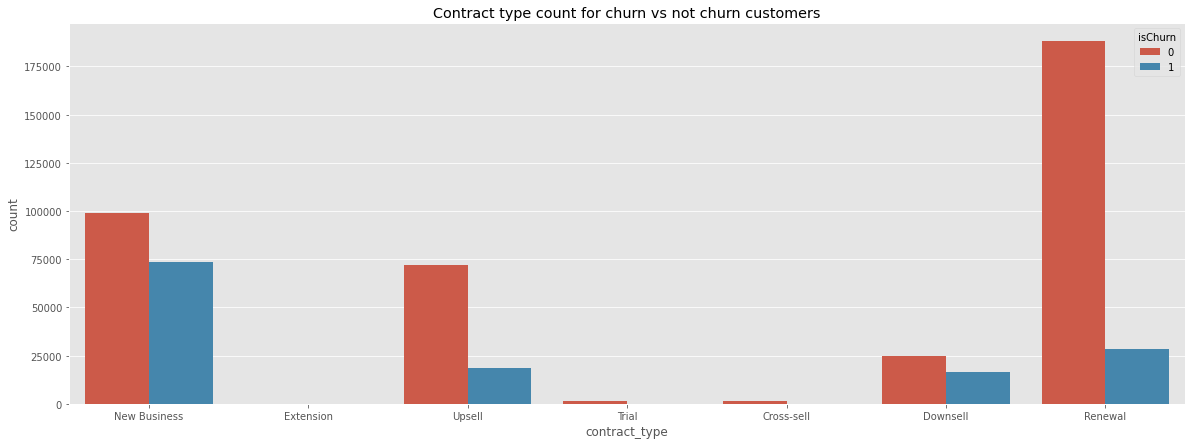

In [25]:
plot = sns.barplot(
    x='contract_type',
    y='count',
    hue='isChurn',
    data=df.groupby('isChurn', 'contract_type').agg(count('contract_type').alias('count')).toPandas()
)
plot.set_title('Contract type count for churn vs not churn customers')

We can see that most customers who are isChurned, they isChurned within 12 months after their contract signed. It's usually around half a year or a year after,

<AxesSubplot:>

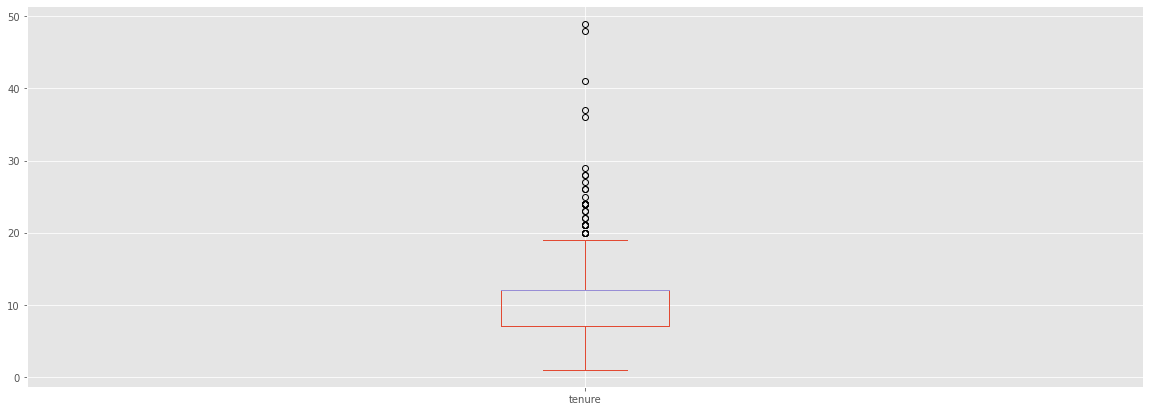

In [26]:
df_business.select('tenure').toPandas().plot.box()

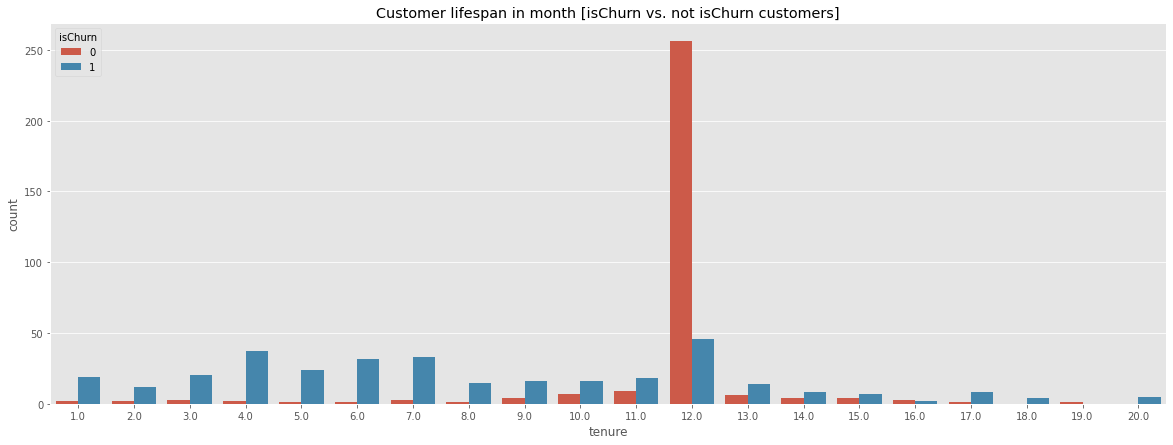

In [27]:
plot = sns.barplot(
    x='tenure',
    y='count',
    hue='isChurn',
    data=df_business.filter('tenure <= 20').groupby('tenure', 'isChurn').count().toPandas()
)
plot.set_title('Customer lifespan in month [isChurn vs. not isChurn customers]')
plot.xaxis.set_major_locator(ticker.FixedLocator(range(0, 21)))